In [139]:
import warnings
import pandas as pd
import numpy as np
import re
import pyecharts as pe
import collections
import matplotlib.pyplot as plt
from pyecharts.charts import Pie, Grid, Bar, Line, Boxplot, WordCloud
from pyecharts.faker import Faker  # 数据包
from pyecharts.charts import Map, Geo
from pyecharts import options as opts
from pyecharts.globals import ThemeType
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']  # 图表可以显示中文



## 数据概览

In [141]:
df = pd.read_excel("movies/豆瓣Top250.xlsx")
# 查看前5行
df.head()
# 获取数据列名
df.columns


Index(['排名', '评分', '电影名称', '导演', '编剧', '主演', '类型', '制片国家/地区', '语言', '上映日期',
       '片长', '又名', 'IMDb', '评分人数', '短评', '豆瓣链接'],
      dtype='object')

In [142]:
columns_remain = ['排名', '电影名称', '又名', '导演', '编剧', '主演', '类型',
                  '制片国家/地区', '上映日期', '片长', '评分', '评分人数',  '短评', '豆瓣链接']
df = df[columns_remain]


In [143]:
# 查看数据的基本信息
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   排名       250 non-null    int64  
 1   电影名称     250 non-null    object 
 2   又名       248 non-null    object 
 3   导演       250 non-null    object 
 4   编剧       249 non-null    object 
 5   主演       249 non-null    object 
 6   类型       250 non-null    object 
 7   制片国家/地区  250 non-null    object 
 8   上映日期     250 non-null    object 
 9   片长       250 non-null    object 
 10  评分       250 non-null    float64
 11  评分人数     250 non-null    int64  
 12  短评       250 non-null    object 
 13  豆瓣链接     250 non-null    object 
dtypes: float64(1), int64(2), object(11)
memory usage: 27.5+ KB


In [155]:
# 判断哪些列有空值
df.isnull().any()

排名         False
电影名称       False
又名          True
导演         False
编剧          True
主演          True
类型         False
制片国家/地区    False
上映日期       False
片长         False
评分         False
评分人数       False
短评         False
豆瓣链接       False
dtype: bool

In [154]:
df_ = df.isnull().any()
df_[df_ == True]


又名    True
编剧    True
主演    True
dtype: bool

主演、编剧这两列有空值，数据有249条，说明存在1个空值，详细看一下是哪一部电影；
评分列格式是浮点型，评分人数是整型，都没有空值，后面可以直接进行分析


In [6]:
# 筛选出主演为空值的数据
df[df['主演'].isnull()]


,排名,电影名称,又名,导演,编剧,主演,类型,制片国家/地区,上映日期,片长,评分,评分人数,短评,豆瓣链接
205,206,二十二,TwentyTwo/22,郭柯,NaN,NaN,纪录片,中国大陆,2017-08-14(中国大陆)/2015-10-05(釜山电影节)/2016-06-25(...,99分钟(公映版)/112分钟,8.7,265913,有一些东西不应该被遗忘。,https://movie.douban.com/subject/26430107/


纪录片《二十二》的主演有空值，这个空值填充“缺失数据”

In [7]:
df.fillna('缺失数据', inplace=True)
df.isnull().any()


排名         False
电影名称       False
又名         False
导演         False
编剧         False
主演         False
类型         False
制片国家/地区    False
上映日期       False
片长         False
评分         False
评分人数       False
短评         False
豆瓣链接       False
dtype: bool

In [8]:
# 查看离散型变量的情况
df.describe()


,排名,评分,评分人数
count,250.000000,250.000000,2.500000e+02
mean,125.500000,8.917600,6.499965e+05
std,72.312977,0.267688,4.019263e+05
min,1.000000,8.300000,8.901500e+04
25%,63.250000,8.700000,3.791648e+05
50%,125.500000,8.900000,5.394915e+05
75%,187.750000,9.100000,7.852802e+05
max,250.000000,9.700000,2.533625e+06


评分情况，平均值8.918，最高评分9.7，最低分8.3分，后面进行可视化处理

## 数据清洗

豆瓣top250榜单详细电影名称

In [156]:
# 获取榜单里电影名称的中文名称
df['电影名称'] = df['电影名称'].apply(lambda x: x.split(' ')[0])
print(df['电影名称'].values.tolist()[0:10])


['肖申克的救赎', '霸王别姬', '阿甘正传', '泰坦尼克号', '这个杀手不太冷', '美丽人生', '千与千寻', '辛德勒的名单', '盗梦空间', '忠犬八公的故事']


很多单元格数据是以“/”来分割的，需要转化为列表形式，便于进行分析；

上映日期只要具体年份（年），片长只要具体时长（分钟）


In [157]:
string = '1998-04-03(中国大陆)/1997-11-01(东京电影节)/1997-12-19(美国)'
find = re.compile('\d{4}')
date = find.findall(string)
min(date)


'1997'

In [164]:
str = "弗兰克·德拉邦特"
str.split('/')

['弗兰克·德拉邦特']

In [162]:
# 定义函数，将用"/" 分割的数据转化为列表
def conver_list(df, *columns):
    for column in columns:
        df[column] = df[column].str.split('/')
    return df


# 定义函数，用来获取最早上映日期
def get_date(x):
    find = re.compile('\d{4}')
    date = find.findall(x)
    earliest=min(date)
    return earliest


# '上映日期'和'片长'这两列，取具体的数字
df['上映日期'] = df['上映日期'].apply(get_date)
df['片长'] = df['片长'].apply(lambda x: x.split('分钟')[0]).astype('int')

#  '导演', '主演', '类型', '制片国家/地区'，这几列的值转化为列表
df = conver_list(df, '导演',"编剧",'主演', '类型', '制片国家/地区')

df.head(n=2)


,排名,电影名称,又名,导演,编剧,主演,类型,制片国家/地区,上映日期,片长,评分,评分人数,短评,豆瓣链接
0,1,肖申克的救赎,月黑高飞(港)/刺激1995(台)/地狱诺言/铁窗岁月/消香克的救赎,NaN,NaN,NaN,NaN,NaN,1994,142,9.7,2533625,希望让人自由。,https://movie.douban.com/subject/1292052/
1,2,霸王别姬,再见，我的妾/FarewellMyConcubine/AdieuMaConcubine,NaN,NaN,NaN,NaN,NaN,1993,171,9.6,1883284,风华绝代。,https://movie.douban.com/subject/1291546/


In [160]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   排名       250 non-null    int64  
 1   电影名称     250 non-null    object 
 2   又名       248 non-null    object 
 3   导演       250 non-null    object 
 4   编剧       249 non-null    object 
 5   主演       249 non-null    object 
 6   类型       250 non-null    object 
 7   制片国家/地区  250 non-null    object 
 8   上映日期     250 non-null    object 
 9   片长       250 non-null    int32  
 10  评分       250 non-null    float64
 11  评分人数     250 non-null    int64  
 12  短评       250 non-null    object 
 13  豆瓣链接     250 non-null    object 
dtypes: float64(1), int32(1), int64(2), object(10)
memory usage: 26.5+ KB


## 分析及可视化

### 电影上映日期分布情况

In [12]:
# 获取每一年上映的电影数量
df["上映日期"].value_counts()

1994    13
2010    13
2004    13
2015    11
2013    11
2016    10
2003    10
2008    10
2001     9
2014     9
2009     9
2006     9
2011     8
2002     8
1997     8
1995     7
1993     7
2018     6
1999     6
2000     5
2017     5
2012     5
1998     4
2005     4
1988     4
1991     4
2007     4
1990     3
1987     3
1989     2
1996     2
1992     2
2019     2
1986     2
1957     2
1984     2
1939     1
1968     1
1953     1
1979     1
1931     1
1960     1
1936     1
1972     1
1966     1
1954     1
1974     1
1961     1
1940     1
1952     1
1965     1
1982     1
1950     1
1975     1
Name: 上映日期, dtype: int64

In [13]:
df["上映日期"].value_counts().sort_index()


1931     1
1936     1
1939     1
1940     1
1950     1
1952     1
1953     1
1954     1
1957     2
1960     1
1961     1
1965     1
1966     1
1968     1
1972     1
1974     1
1975     1
1979     1
1982     1
1984     2
1986     2
1987     3
1988     4
1989     2
1990     3
1991     4
1992     2
1993     7
1994    13
1995     7
1996     2
1997     8
1998     4
1999     6
2000     5
2001     9
2002     8
2003    10
2004    13
2005     4
2006     9
2007     4
2008    10
2009     9
2010    13
2011     8
2012     5
2013    11
2014     9
2015    11
2016    10
2017     5
2018     6
2019     2
Name: 上映日期, dtype: int64

In [123]:
from pyecharts.charts import Bar
from pyecharts import options as opts


x1 = list(df["上映日期"].value_counts().sort_index().index)
y1 = list(df["上映日期"].value_counts().sort_index().values)
y1 = [str(i) for i in y1]
year = (
    Bar()
    .add_xaxis(x1)
    .add_yaxis("影片数量", y1)
    .set_global_opts(
        title_opts=opts.TitleOpts(title="豆瓣电影Top250上映日期分布情况"),
        xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(rotate=90)),
        toolbox_opts=opts.ToolboxOpts(
            is_show=True,
            pos_top="top",
            pos_left="right",
            feature={
                    "saveAsImage": {"pixel_ratio": 2},
                    "dataZoom": {"yAxisIndex": "none"},
                    "restore": {},
                    "magicType": {"show": True, "type": ["line", "bar"]},
                    "dataView": {}}

        )
        # datazoom_opts=opts.DataZoomOpts(),
    )
)

year.render("anlysis/电影上映日期分布情况.html")

year.render_notebook()


豆瓣top250电影中，最早的一部是在1931年，名称是卓别林主演的《城市之光》，最新一部是在2019年上映的《寄生虫》，大部分电影上映年份分布在1987年到2019年之间，其中，1994,2004,2010年最多，都是13部


In [15]:
df[df['上映日期'] == '1931']


,排名,电影名称,又名,导演,编剧,主演,类型,制片国家/地区,上映日期,片长,评分,评分人数,短评,豆瓣链接
197,198,城市之光,CityLights,[查理·卓别林],"[查理·卓别林, HarryClive, 哈里·克罗克]","[查理·卓别林, 弗吉尼亚·切瑞尔, 佛罗伦斯·李, 亨利·伯格曼, 珍·哈露]","[剧情, 喜剧, 爱情]",[美国],1931,87,9.3,122119,永远的小人物，伟大的卓别林。,https://movie.douban.com/subject/1293908/


In [16]:
df[df['上映日期'] == '2019']


,排名,电影名称,又名,导演,编剧,主演,类型,制片国家/地区,上映日期,片长,评分,评分人数,短评,豆瓣链接
147,148,寄生虫,寄生上流(台)/上流寄生族(港)/패러사이트/Parasite/Gisaengchung,[奉俊昊],"[奉俊昊, 韩珍元]","[宋康昊, 李善均, 赵汝贞, 崔宇植, 朴素丹, 李姃垠, 张慧珍, 郑知晓, 朴明勋, ...","[剧情, 喜剧]",[韩国],2019,132,8.8,1204354,\n,https://movie.douban.com/subject/27010768/
227,228,小丑,小丑起源电影：罗密欧/Romeo/JokerOriginMovie,[托德·菲利普斯],"[托德·菲利普斯, 斯科特·西尔弗, 鲍勃·凯恩, 比尔·芬格, 杰瑞·罗宾逊]","[华金·菲尼克斯, 罗伯特·德尼罗, 马克·马龙, 莎姬·贝兹, 谢伊·惠格姆, 弗兰西丝·...","[剧情, 惊悚, 犯罪]","[美国, 加拿大]",2019,122,8.7,878629,\n,https://movie.douban.com/subject/27119724/


In [17]:
df_=df[df['上映日期'] == '1994'][["排名",'电影名称']]
print(df_.to_markdown(index=False))


|   排名 | 电影名称       |
|-------:|:---------------|
|      1 | 肖申克的救赎   |
|      3 | 阿甘正传       |
|      5 | 这个杀手不太冷 |
|     30 | 活着           |
|     59 | 狮子王         |
|     62 | 饮食男女       |
|     85 | 低俗小说       |
|    109 | 重庆森林       |
|    112 | 阳光灿烂的日子 |
|    177 | 九品芝麻官     |
|    182 | 东邪西毒       |
|    223 | 背靠背，脸对脸 |
|    230 | 燃情岁月       |


In [18]:
# 保存电影元年诞生的经典电影
myears = ['1994', '2004', '2010']
for myear in myears:
    df_ = df[df['上映日期'] == myear]
    df_.to_excel(f"movies/{myear}年上映的电影(共{len(df_)}部).xlsx", index=False)


### 电影制片国家地区分布情况

In [19]:
# 把各个电影制片国家地区的列表合并成一个大列表
area_list = []
for i in df['制片国家/地区']:
    area_list.extend(i)
area_list[:10]


['美国', '中国大陆', '中国香港', '美国', '美国', '墨西哥', '澳大利亚', '加拿大', '法国', '美国']

制片国家/地区的总数量超过250,是因为部分电影是多个国家或地区合作的

In [20]:
len(area_list)


382

In [21]:
len(area_list)
area_count = collections.Counter(area_list)
print(area_count)


Counter({'美国': 138, '日本': 35, '英国': 35, '中国香港': 30, '中国大陆': 25, '法国': 19, '德国': 17, '韩国': 12, '意大利': 10, '加拿大': 9, '中国台湾': 8, '澳大利亚': 5, '印度': 4, '瑞士': 4, '西班牙': 4, '新西兰': 3, '瑞典': 2, '巴西': 2, '墨西哥': 1, '黎巴嫩': 1, '塞浦路斯': 1, '卡塔尔': 1, '波兰': 1, '伊朗': 1, '丹麦': 1, '荷兰': 1, '奥地利': 1, '南非': 1, '阿根廷': 1, '希腊': 1, '泰国': 1, '爱尔兰': 1, '阿联酋': 1, '摩纳哥': 1, '捷克': 1, '比利时': 1, '匈牙利': 1, '约旦': 1})


In [22]:
sort_area_count = sorted(area_count.items(), key=lambda x: x[1], reverse=True)
sort_area_count[:5]


[('美国', 138), ('日本', 35), ('英国', 35), ('中国香港', 30), ('中国大陆', 25)]

In [23]:
# 将排序后的字典转化为新的列表，作为横坐标轴、纵坐标轴
x2 = [x[0] for x in sort_area_count]
y2 = [x[1] for x in sort_area_count]


In [101]:
area = Bar()
area.add_xaxis(x2)
area.add_yaxis("影片数量", y2)
area.set_global_opts(
    title_opts=opts.TitleOpts(title="豆瓣电影Top250制片国家/地区分布情况"),
    xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(rotate=80)),
    toolbox_opts=opts.ToolboxOpts(
        is_show=True,
        pos_top="top",
        pos_left="right",
        feature={
            "saveAsImage": {"pixel_ratio": 2},
            "dataZoom": {"yAxisIndex": "none"},
            "restore": {},
            "magicType": {},
            "dataView": {}}

    )
    # datazoom_opts=opts.DataZoomOpts(),
)

area.render("anlysis/电影制片国家地区分布情况.html")
area.render_notebook()


豆瓣top250电影，有138部电影是美国出品的，超过一半；中国（含大陆、香港、台湾）出品的有46部,接着是日本和英国

In [126]:
from pyecharts.charts import WordCloud

c = (
    WordCloud()
    .add(
        "",
        sort_area_count,
        word_size_range=[20, 100],
        textstyle_opts=opts.TextStyleOpts(font_family="cursive"),
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(title="豆瓣电影Top250中制片国家地区分布情况词云"),
        toolbox_opts=opts.ToolboxOpts(
            is_show=True,
            pos_top="top",
            pos_left="right",
            feature={
                "saveAsImage": {},
                "dataZoom": {"yAxisIndex": "none"},
                "restore": {},
                "magicType": {},
                "dataView": {}}
        )
        )

)
c.render("anlysis/电影制片国家地区分布情况词云.html")
c.render_notebook()


纪录片《二十二》的主演有空值，这个空值填充“缺失数据”

In [26]:
def find_China(area_list):
    find = re.compile('中国+')
    flag = False
    for i in area_list:
        m = find.search(i)
        if m:
            return True
    return False


def find_all_China(area_list):
    # 国产电影就是制片国家/地区第一个是中国的电影
    find = re.compile('中国+')
    m = find.search(area_list[0])
    if not m:
        return False
    return True


# sum([find_China(x) for x in df["制片国家/地区"].tolist()])

# sum([find_all_China(x) for x in df["制片国家/地区"].tolist()])


In [27]:
df_=df[[find_China(x) for x in df["制片国家/地区"].tolist()]]
df_.to_excel(f"movies/中国参与制片的电影(共{len(df_)}部).xlsx", index=False)


In [28]:
df_ = df[[find_all_China(x) for x in df["制片国家/地区"].tolist()]]
df_.to_excel(f"movies/国产电影(共{len(df_)}部).xlsx", index=False)


### 电影类型分布情况

In [29]:
type_list = []
for i in df['类型']:
    type_list.extend(i)

type_count = collections.Counter(type_list)
sort_type_count = sorted(type_count.items(), key=lambda x: x[1], reverse=True)

In [30]:
# 将排序后的字典转化为新的列表，作为横坐标轴、纵坐标轴
x3 = [x[0] for x in sort_type_count]
y3 = [x[1] for x in sort_type_count]
word_counts = [[word[0], word[1]] for word in sort_type_count]
print('250部电影标签总数是：{}，平均每部电影标签数量是：{}。'.format(sum(y3), sum(y3)/250))


250部电影标签总数是：694，平均每部电影标签数量是：2.776。


In [31]:
word_counts


[['剧情', 189],
 ['爱情', 57],
 ['喜剧', 56],
 ['冒险', 46],
 ['犯罪', 42],
 ['奇幻', 40],
 ['动画', 36],
 ['惊悚', 33],
 ['动作', 31],
 ['悬疑', 29],
 ['科幻', 23],
 ['家庭', 20],
 ['战争', 15],
 ['传记', 15],
 ['古装', 10],
 ['同性', 8],
 ['历史', 8],
 ['音乐', 8],
 ['歌舞', 6],
 ['儿童', 5],
 ['武侠', 4],
 ['西部', 3],
 ['纪录片', 3],
 ['灾难', 2],
 ['情色', 2],
 ['恐怖', 2],
 ['运动', 1]]

In [127]:

tag = (
    #创建一个饼图
    Pie(init_opts=opts.InitOpts(width="1000px", height="500px")) 
    # 添加数据
    .add(
        "",  
        sort_type_count  # 数据
    )
    # 设置标签格式，b-名称，c是计数，d是概率
    .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}: {c}({d}%)"))
    .set_global_opts(
        #标题
        title_opts=opts.TitleOpts(title="豆瓣电影Top250电影类型分布情况"),
        # 图例的布局朝向。可选：'horizontal', 'vertical'
        legend_opts=opts.LegendOpts(
            orient="vertical", pos_top="0%",pos_right="8%" # 图例设置
        ),
        #工具栏
        toolbox_opts=opts.ToolboxOpts(
            is_show=True,
            pos_top="bottom",
            pos_left="right",
            feature={
                "saveAsImage": {},
                "dataZoom": {"yAxisIndex": "none"},
                "restore": {},
                "magicType": {},
                "dataView": {}}
        )
    )

)
tag.render('anlysis/电影类型分布情况.html')  # 保存到本地
tag.render_notebook()


可以看出，250部电影类型标签众多，有剧情、爱情、犯罪等等，恐怖片也有上榜，是《电锯惊魂》和《惊魂记》。跟制片国家/地区一样，一部电影可能有多个标签，所有类型标签加起来总共有694个，平均每部电影有2.776个标签，27.23%的标签是剧情，并不意味着有27.23%的电影是属于剧情片，实际上，剧情标签数量是189个，意味着250部电影里有189是属于剧情电影，占比达到75.6%，接近3/4。

In [33]:
df[['恐怖' in x for x in df['类型'].tolist()]]['电影名称']


155    电锯惊魂
171     惊魂记
Name: 电影名称, dtype: object

In [34]:

print("剧情片数量:", type_count['剧情'])
print("比例为:", type_count['剧情']/250)


剧情片数量: 189
比例为: 0.756


In [35]:
# 保存感兴趣的标签的电影
tags=['爱情','科幻','动画','悬疑','喜剧','惊悚']
for tag in tags:
    df_ = df[[tag in x for x in df['类型'].tolist()]]
    df_.to_excel(f"movies/标签-{tag}电影(共{len(df_)}部).xlsx",index=False)


In [ ]:
import os 
def mkdir(path):
    if not os.path.exists(path):
        os.mkdir(path)
    else:
        print("路径已存在")

In [128]:

c = (
    WordCloud()
    .add(
        "",
        sort_type_count,
        word_size_range=[20, 100],
        textstyle_opts=opts.TextStyleOpts(font_family="cursive"),
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(title="电影类型分布词云"),
        #工具栏
        toolbox_opts=opts.ToolboxOpts(
        is_show=True,
        pos_top="top",
        pos_left="right",
        feature={
                "saveAsImage": {},
                "dataZoom": {"yAxisIndex": "none"},
                "restore": {},
                "magicType": {},
                "dataView": {}}
    )
    )
    
)
c.render("anlysis/电影类型分布词云.html")
c.render_notebook()


### 电影导演分析

In [38]:
director_list = []
for x in df['导演']:
    director_list.extend(x)
director_count = collections.Counter(director_list)
sort_director_count = sorted(
    director_count.items(), key=lambda x: x[1], reverse=True)


In [39]:
sort_director_count


[('宫崎骏', 8),
 ('史蒂文·斯皮尔伯格', 6),
 ('克里斯托弗·诺兰', 6),
 ('李安', 5),
 ('王家卫', 5),
 ('大卫·芬奇', 4),
 ('今敏', 4),
 ('是枝裕和', 4),
 ('詹姆斯·卡梅隆', 3),
 ('朱塞佩·托纳多雷', 3),
 ('刘镇伟', 3),
 ('弗朗西斯·福特·科波拉', 3),
 ('李·昂克里奇', 3),
 ('彼得·杰克逊', 3),
 ('彼特·道格特', 3),
 ('姜文', 3),
 ('莉莉·沃卓斯基', 3),
 ('拉娜·沃卓斯基', 3),
 ('昆汀·塔伦蒂诺', 3),
 ('理查德·林克莱特', 3),
 ('弗兰克·德拉邦特', 2),
 ('彼得·威尔', 2),
 ('刘伟强', 2),
 ('麦兆辉', 2),
 ('瑞奇·摩尔', 2),
 ('罗伯·莱纳', 2),
 ('克里斯·哥伦布', 2),
 ('查理·卓别林', 2),
 ('周星驰', 2),
 ('李力持', 2),
 ('奉俊昊', 2),
 ('中岛哲也', 2),
 ('蒂姆·波顿', 2),
 ('梅尔·吉布森', 2),
 ('森淳一', 2),
 ('杨德昌', 2),
 ('克里斯·桑德斯', 2),
 ('理查德·柯蒂斯', 2),
 ('黑泽明', 2),
 ('保罗·格林格拉斯', 2),
 ('吴宇森', 2),
 ('达米恩·查泽雷', 2),
 ('丹尼·博伊尔', 2),
 ('爱德华·兹威克', 2),
 ('安德鲁·尼科尔', 2),
 ('陈凯歌', 1),
 ('罗伯特·泽米吉斯', 1),
 ('吕克·贝松', 1),
 ('罗伯托·贝尼尼', 1),
 ('拉斯·霍尔斯道姆', 1),
 ('拉吉库马尔·希拉尼', 1),
 ('安德鲁·斯坦顿', 1),
 ('克里斯托夫·巴拉蒂', 1),
 ('拜伦·霍华德', 1),
 ('杰拉德·布什', 1),
 ('黄东赫', 1),
 ('加布里埃莱·穆奇诺', 1),
 ('比利·怀尔德', 1),
 ('奥利维埃·纳卡什', 1),
 ('埃里克·托莱达诺', 1),
 ('贝纳尔多·贝托鲁奇', 1),
 ('阿德里安·莫利纳', 1),
 ('张艺谋', 1),
 ('维克多·

In [111]:


x4 = [x[0] for x in sort_director_count][:20]
y4 = [x[1] for x in sort_director_count][:20]
director = (
    Bar(init_opts=opts.InitOpts(width="1200px", height="600px"))
    .add_xaxis(x4)
    .add_yaxis("影片数量", y4)
    .set_global_opts(
        title_opts=opts.TitleOpts(title="豆瓣电影Top250导演数量分布情况(前20位导演)"),
        xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(rotate=20)),
        toolbox_opts=opts.ToolboxOpts(
            is_show=True,
            pos_top="top",
            pos_left="right",
            feature={
                "saveAsImage": {},
                "dataZoom": {"yAxisIndex": "none"},
                "restore": {},
                "magicType": {"show": True, "type": ["line", "bar"]},
                
                "dataView": {}}
        )
        # datazoom_opts=opts.DataZoomOpts(),
    )
) 


director.render("anlysis/电影导演分析.html")
director.render_notebook()


In [129]:


c = (
    WordCloud()
    .add(
        "",
        sort_director_count,
        word_size_range=[20, 100],
        textstyle_opts=opts.TextStyleOpts(font_family="cursive"),
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(title="电影导演分析词云"),
        toolbox_opts=opts.ToolboxOpts(
            is_show=True,
            pos_top="top",
            pos_left="right",
            feature={
                "saveAsImage": {},
                "dataZoom": {"yAxisIndex": "none"},
                "restore": {},
                "magicType": {},
                "dataView": {}}
        )
    )

)
c.render("anlysis/电影导演分析词云.html")
c.render_notebook()


可以看到，宫崎骏第一，有8部电影入围豆瓣top250，史蒂文·斯皮尔伯格和克里斯托弗·诺兰都有6部入围豆瓣top250,中国导演李安、王家卫分别都有5部电影入围豆瓣top250，刘镇伟、姜文分别有3部电影入围豆瓣top250，
看一下克里斯托弗·诺兰有哪些电影入围豆瓣top250

In [42]:
df[['克里斯托弗·诺兰' in x for x in df['导演'].tolist()]]['电影名称']


8            盗梦空间
10           星际穿越
28       蝙蝠侠：黑暗骑士
77           致命魔术
114    蝙蝠侠：黑暗骑士崛起
172          记忆碎片
Name: 电影名称, dtype: object

星爷的喜剧之王和功夫入围豆瓣top250

In [43]:
df[['周星驰' in x for x in df['导演'].tolist()]]['电影名称']


88    喜剧之王
95      功夫
Name: 电影名称, dtype: object

In [44]:
df[['李安' in x for x in df['导演'].tolist()]]['电影名称']


40     少年派的奇幻漂流
61         饮食男女
102         断背山
153          喜宴
189         色，戒
Name: 电影名称, dtype: object

In [45]:
df[['宫崎骏' in x for x in df['导演'].tolist()]]['电影名称']


6         千与千寻
24          龙猫
39     哈尔的移动城堡
43        天空之城
107       幽灵公主
164        风之谷
196      魔女宅急便
231      崖上的波妞
Name: 电影名称, dtype: object

In [46]:
df[['史蒂文·斯皮尔伯格' in x for x in df['导演'].tolist()]]['电影名称']


7      辛德勒的名单
44       猫鼠游戏
70     拯救大兵瑞恩
128     幸福终点站
148      头号玩家
201      人工智能
Name: 电影名称, dtype: object

In [47]:
df[['王家卫' in x for x in df['导演'].tolist()]]['电影名称']

85     春光乍泄
108    重庆森林
157    花样年华
181    东邪西毒
233    阿飞正传
Name: 电影名称, dtype: object

### 电影编剧分析

In [48]:
screenwriter_list = []
for x in df['编剧']:
    screenwriter_list.extend(x)
screenwriter_count = collections.Counter(screenwriter_list)
sort_screenwriter_count = sorted(
    screenwriter_count.items(), key=lambda x: x[1], reverse=True)
sort_screenwriter_count



[('宫崎骏', 10),
 ('克里斯托弗·诺兰', 6),
 ('乔纳森·诺兰', 5),
 ('史蒂夫·克洛夫斯', 5),
 ('J.K.罗琳', 5),
 ('王家卫', 5),
 ('安德鲁·尼科尔', 4),
 ('彼特·道格特', 4),
 ('是枝裕和', 4),
 ('詹姆斯·卡梅隆', 3),
 ('朱塞佩·托纳多雷', 3),
 ('安德鲁·斯坦顿', 3),
 ('吉姆·里尔顿', 3),
 ('刘镇伟', 3),
 ('马里奥·普佐', 3),
 ('弗朗西斯·福特·科波拉', 3),
 ('弗兰·威尔士', 3),
 ('菲利帕·鲍恩斯', 3),
 ('彼得·杰克逊', 3),
 ('J.R.R.托尔金', 3),
 ('姜文', 3),
 ('莉莉·沃卓斯基', 3),
 ('拉娜·沃卓斯基', 3),
 ('詹姆斯·夏慕斯', 3),
 ('昆汀·塔伦蒂诺', 3),
 ('今敏', 3),
 ('理查德·林克莱特', 3),
 ('金·克里桑', 3),
 ('托尼·吉尔罗伊', 3),
 ('弗兰克·德拉邦特', 2),
 ('斯蒂芬·金', 2),
 ('芦苇', 2),
 ('李碧华', 2),
 ('艾瑞克·罗斯', 2),
 ('新藤兼人', 2),
 ('麦兆辉', 2),
 ('庄文强', 2),
 ('瑞奇·摩尔', 2),
 ('菲尔·约翰斯顿', 2),
 ('珍妮弗·李', 2),
 ('斯蒂夫·康拉德', 2),
 ('李·昂克里奇', 2),
 ('大卫·S·高耶', 2),
 ('鲍勃·彼德森', 2),
 ('汤姆·麦卡锡', 2),
 ('述平', 2),
 ('杰夫·内桑森', 2),
 ('博·古德曼', 2),
 ('乔纳森·罗伯特', 2),
 ('李安', 2),
 ('王蕙玲', 2),
 ('查理·卓别林', 2),
 ('曾瑾昌', 2),
 ('周星驰', 2),
 ('奉俊昊', 2),
 ('中岛哲也', 2),
 ('筒井康隆', 2),
 ('陈文强', 2),
 ('森淳一', 2),
 ('五十岚大介', 2),
 ('杨德昌', 2),
 ('丹尼尔·吉尔森', 2),
 ('罗伯特·L·贝尔德', 2),
 ('朱莉·德尔佩', 2),
 ('伊桑·霍克', 2)

In [120]:
xs = [x[0] for x in sort_screenwriter_count][:20]
ys = [x[1] for x in sort_screenwriter_count][:20]
sort_screenwriter = (
    Bar(init_opts=opts.InitOpts(width="1200px", height="600px"))
    .add_xaxis(xs)
    .add_yaxis("影片数量", ys)
    .set_global_opts(
        title_opts=opts.TitleOpts(title="豆瓣电影Top250编剧数量分布情况(前20位编剧)"),
        xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(rotate=20)),
        # datazoom_opts=opts.DataZoomOpts(),
        toolbox_opts=opts.ToolboxOpts(
            is_show=True,
            pos_top="top",
            pos_left="right",
            feature={
                "saveAsImage": {},
                "dataZoom": {"yAxisIndex": "none"},
                "restore": {},
                "magicType": {"show": True, "type": ["line", "bar"]},
                "dataView": {}}
        )
    )
)


sort_screenwriter.render("anlysis/电影编剧分析.html")
sort_screenwriter.render_notebook()


In [130]:


c = (
    WordCloud()
    .add(
        "",
        sort_screenwriter_count,
        word_size_range=[20, 100],
        textstyle_opts=opts.TextStyleOpts(font_family="cursive"),
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(title="电影编剧分析词云"),
        toolbox_opts=opts.ToolboxOpts(
            is_show=True,
            pos_top="top",
            pos_left="right",
            feature={
                "saveAsImage": {},
                "dataZoom": {"yAxisIndex": "none"},
                "restore": {},
                "magicType": {},
                "dataView": {}}
        ))

)
c.render("anlysis/电影编剧分析词云.html")
c.render_notebook()


豆瓣电影Top250中，宫崎骏参与编剧的电影高达10部！其中8部是自己导演的，只有两部《侧耳倾听》和《借东西的小人阿莉埃蒂》分别是近藤喜文、米林宏昌导演。



In [51]:
df_=df[['宫崎骏' in x for x in df['编剧'].tolist()]][['电影名称', '导演', '编剧']]
print(df_.to_markdown(index=False).replace(
    "[", "").replace("]", "").replace("'", ""))


| 电影名称             | 导演         | 编剧                                |
|:---------------------|:-------------|:------------------------------------|
| 千与千寻             | 宫崎骏   | 宫崎骏                          |
| 龙猫                 | 宫崎骏   | 宫崎骏                          |
| 哈尔的移动城堡       | 宫崎骏   | 宫崎骏, 黛安娜·温恩·琼斯      |
| 天空之城             | 宫崎骏   | 宫崎骏                          |
| 幽灵公主             | 宫崎骏   | 宫崎骏                          |
| 侧耳倾听             | 近藤喜文 | 宫崎骏, 柊葵                  |
| 借东西的小人阿莉埃蒂 | 米林宏昌 | 宫崎骏, 丹羽圭子, 玛丽·诺顿 |
| 风之谷               | 宫崎骏   | 宫崎骏                          |
| 魔女宅急便           | 宫崎骏   | 宫崎骏, 角野荣子              |
| 崖上的波妞           | 宫崎骏   | 宫崎骏                          |


克里斯托弗·诺兰和他兄弟乔纳森·诺兰分布荣登豆瓣电影Top250中参与编剧数量第二、第三名，豆瓣电影Top250中，克里斯托弗·诺兰导演的影片除了一部《盗门空间》是自己编剧，其他的五部电影《星际穿越》《蝙蝠侠：黑暗骑士》《致命魔术》《蝙蝠侠：黑暗骑士崛起》《记忆碎片》电影都和兄弟有合作编写剧本

In [52]:
df_=df[['克里斯托弗·诺兰' in x for x in df['编剧'].tolist()]][['电影名称', '导演', '编剧']]
print(df_.to_markdown(index=False).replace("[","").replace("]","").replace("'",""))


| 电影名称             | 导演                | 编剧                                                      |
|:---------------------|:--------------------|:----------------------------------------------------------|
| 盗梦空间             | 克里斯托弗·诺兰 | 克里斯托弗·诺兰                                       |
| 星际穿越             | 克里斯托弗·诺兰 | 乔纳森·诺兰, 克里斯托弗·诺兰                        |
| 蝙蝠侠：黑暗骑士     | 克里斯托弗·诺兰 | 乔纳森·诺兰, 克里斯托弗·诺兰, 大卫·S·高耶         |
| 致命魔术             | 克里斯托弗·诺兰 | 乔纳森·诺兰, 克里斯托弗·诺兰, 克里斯托弗·普瑞丝特 |
| 蝙蝠侠：黑暗骑士崛起 | 克里斯托弗·诺兰 | 大卫·S·高耶, 乔纳森·诺兰, 克里斯托弗·诺兰         |
| 记忆碎片             | 克里斯托弗·诺兰 | 克里斯托弗·诺兰, 乔纳森·诺兰                        |


In [53]:
df[['乔纳森·诺兰' in x for x in df['编剧'].tolist()]][['电影名称','导演','编剧']]


,电影名称,导演,编剧
10,星际穿越,[克里斯托弗·诺兰],"[乔纳森·诺兰, 克里斯托弗·诺兰]"
28,蝙蝠侠：黑暗骑士,[克里斯托弗·诺兰],"[乔纳森·诺兰, 克里斯托弗·诺兰, 大卫·S·高耶]"
77,致命魔术,[克里斯托弗·诺兰],"[乔纳森·诺兰, 克里斯托弗·诺兰, 克里斯托弗·普瑞丝特]"
114,蝙蝠侠：黑暗骑士崛起,[克里斯托弗·诺兰],"[大卫·S·高耶, 乔纳森·诺兰, 克里斯托弗·诺兰]"
172,记忆碎片,[克里斯托弗·诺兰],"[克里斯托弗·诺兰, 乔纳森·诺兰]"


In [54]:
director_count.get("是",0)


0

In [55]:
director_writer_list=[]

for key,value in screenwriter_count.items():
    li={}
    li["人名"]=key
    li["编剧数量"]=value
    li["导演数量"] = director_count.get(key, 0)
    director_writer_list.append(li)


director_writer_df=pd.DataFrame(director_writer_list)
director_writer_df_20=director_writer_df.sort_values(
    by="编剧数量", ascending=False).iloc[0:20]
director_writer_df_20


,人名,编剧数量,导演数量
10,宫崎骏,10,8
13,克里斯托弗·诺兰,6,6
175,王家卫,5,5
62,J.K.罗琳,5,0
61,史蒂夫·克洛夫斯,5,0
16,乔纳森·诺兰,5,0
25,彼特·道格特,4,3
228,是枝裕和,4,4
17,安德鲁·尼科尔,4,2
6,詹姆斯·卡梅隆,3,3


In [56]:

print(director_writer_df_20.to_markdown(index=False))


| 人名            |   编剧数量 |   导演数量 |
|:----------------|-----------:|-----------:|
| 宫崎骏          |         10 |          8 |
| 克里斯托弗·诺兰 |          6 |          6 |
| 王家卫          |          5 |          5 |
| J.K.罗琳        |          5 |          0 |
| 史蒂夫·克洛夫斯 |          5 |          0 |
| 乔纳森·诺兰     |          5 |          0 |
| 彼特·道格特     |          4 |          3 |
| 是枝裕和        |          4 |          4 |
| 安德鲁·尼科尔   |          4 |          2 |
| 詹姆斯·卡梅隆   |          3 |          3 |
| 莉莉·沃卓斯基   |          3 |          3 |
| 菲利帕·鲍恩斯   |          3 |          0 |
| 弗兰·威尔士     |          3 |          0 |
| 昆汀·塔伦蒂诺   |          3 |          3 |
| 刘镇伟          |          3 |          3 |
| 詹姆斯·夏慕斯   |          3 |          0 |
| 吉姆·里尔顿     |          3 |          0 |
| 安德鲁·斯坦顿   |          3 |          1 |
| 拉娜·沃卓斯基   |          3 |          3 |
| 朱塞佩·托纳多雷 |          3 |          3 |


豆瓣电影Top250中参与编剧最多的20人中,也豆瓣电影Top250参与导演的,一共有13人
豆瓣电影Top250中参与导演最多的20人中,也豆瓣电影Top250参与编剧的,一共有20人,由此可见名导都喜欢改改剧本.

In [57]:
sum(director_writer_df_20["导演数量"]!=0)


13

In [58]:
writer_director_df_20=director_writer_df.sort_values(
    by="导演数量", ascending=False).iloc[0:20][['人名','导演数量','编剧数量']]

writer_director_df_20


,人名,导演数量,编剧数量
10,宫崎骏,8,10
13,克里斯托弗·诺兰,6,6
363,史蒂文·斯皮尔伯格,6,1
130,李安,5,2
175,王家卫,5,5
195,今敏,4,3
228,是枝裕和,4,4
25,彼特·道格特,3,4
39,刘镇伟,3,3
43,弗朗西斯·福特·科波拉,3,3


In [59]:

print(writer_director_df_20.to_markdown(index=False))


| 人名                 |   导演数量 |   编剧数量 |
|:---------------------|-----------:|-----------:|
| 宫崎骏               |          8 |         10 |
| 克里斯托弗·诺兰      |          6 |          6 |
| 史蒂文·斯皮尔伯格    |          6 |          1 |
| 李安                 |          5 |          2 |
| 王家卫               |          5 |          5 |
| 今敏                 |          4 |          3 |
| 是枝裕和             |          4 |          4 |
| 彼特·道格特          |          3 |          4 |
| 刘镇伟               |          3 |          3 |
| 弗朗西斯·福特·科波拉 |          3 |          3 |
| 拉娜·沃卓斯基        |          3 |          3 |
| 朱塞佩·托纳多雷      |          3 |          3 |
| 莉莉·沃卓斯基        |          3 |          3 |
| 理查德·林克莱特      |          3 |          3 |
| 李·昂克里奇          |          3 |          2 |
| 姜文                 |          3 |          3 |
| 彼得·杰克逊          |          3 |          3 |
| 昆汀·塔伦蒂诺        |          3 |          3 |
| 詹姆斯·卡梅隆        |          3 |          3 |
| 麦兆辉               |          2 | 

In [60]:
# 保存df
director_writer_df.sort_values(
    by="导演数量", ascending=False)[['人名', '导演数量', '编剧数量']].to_excel("anlysis/电影导演与编剧数量.xlsx",index=False)


### 电影主演分析



In [61]:
actor_list = []
for x in df['主演']:
    actor_list.extend(x)

actor_count = collections.Counter(actor_list)
sort_actor_count = sorted(
    actor_count.items(), key=lambda x: x[1], reverse=True)

sort_actor_count


[('张国荣', 8),
 ('梁朝伟', 8),
 ('马特·达蒙', 7),
 ('艾伦·瑞克曼', 7),
 ('雨果·维文', 7),
 ('张曼玉', 7),
 ('汤姆·汉克斯', 6),
 ('莱昂纳多·迪卡普里奥', 6),
 ('加里·奥德曼', 6),
 ('周星驰', 6),
 ('伊桑·霍克', 6),
 ('摩根·弗里曼', 5),
 ('拉尔夫·费因斯', 5),
 ('迈克尔·凯恩', 5),
 ('琼·艾伦', 5),
 ('约翰·拉岑贝格', 5),
 ('丹尼尔·雷德克里夫', 5),
 ('艾玛·沃森', 5),
 ('鲁伯特·格林特', 5),
 ('玛吉·史密斯', 5),
 ('汤姆·费尔顿', 5),
 ('邦妮·怀特', 5),
 ('刘嘉玲', 5),
 ('布拉德·皮特', 5),
 ('凯拉·奈特莉', 5),
 ('神木隆之介', 4),
 ('邦尼·亨特', 4),
 ('吴孟达', 4),
 ('阿尔·帕西诺', 4),
 ('朱丽·沃特斯', 4),
 ('维果·莫腾森', 4),
 ('奥兰多·布鲁姆', 4),
 ('肖恩·宾', 4),
 ('凯特·布兰切特', 4),
 ('安迪·瑟金斯', 4),
 ('大塚明夫', 4),
 ('凯瑞-安·莫斯', 4),
 ('山寺宏一', 4),
 ('林青霞', 4),
 ('树木希林', 4),
 ('邹兆龙', 4),
 ('巩俐', 3),
 ('葛优', 3),
 ('海利·乔·奥斯蒙', 3),
 ('伯纳德·希尔', 3),
 ('丹尼·爱罗', 3),
 ('连姆·尼森', 3),
 ('汤姆·哈迪', 3),
 ('基里安·墨菲', 3),
 ('玛丽昂·歌迪亚', 3),
 ('拉什·费加', 3),
 ('安妮·海瑟薇', 3),
 ('卡西·阿弗莱克', 3),
 ('乔什·斯图沃特', 3),
 ('阿米尔·汗', 3),
 ('杰斯·哈梅尔', 3),
 ('雅克·贝汉', 3),
 ('曾志伟', 3),
 ('陈冠希', 3),
 ('J·K·西蒙斯', 3),
 ('艾伦·图代克', 3),
 ('凯蒂·洛斯', 3),
 ('蓝洁瑛', 3),
 ('莫文蔚', 3),
 ('李健仁', 3),
 ('詹姆斯·肯恩', 

In [116]:

x6 = [x[0] for x in sort_actor_count][:20]
y6 = [x[1] for x in sort_actor_count][:20]
actor = (
    Bar(init_opts=opts.InitOpts(width="1000px", height="500px"))
    .add_xaxis(x6)
    .add_yaxis("影片数量", y6)
    .set_global_opts(
        title_opts=opts.TitleOpts(title="豆瓣电影Top250主演数量分布情况(前20位演员)"),
        xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(rotate=40)),
        # datazoom_opts=opts.DataZoomOpts(),
        toolbox_opts=opts.ToolboxOpts(
            is_show=True,
            pos_top="top",
            pos_left="right",
            feature={
                "saveAsImage": {},
                "dataZoom": {"yAxisIndex": "none"},
                "restore": {},
                "magicType": {"show": True, "type": ["line", "bar"]},
                "dataView": {}}
        )
    )
)
grid=Grid()
grid.add(actor, grid_opts=opts.GridOpts(pos_bottom="20%"))
grid.render("anlysis/电影主演分析.html")
grid.render_notebook()


In [131]:
word = sort_actor_count
c = (
    WordCloud()
    .add(
        "",
        word,
        word_size_range=[20, 100],
        textstyle_opts=opts.TextStyleOpts(font_family="cursive"),
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(title="电影主演分析词云")    ,
        toolbox_opts=opts.ToolboxOpts(
        is_show=True,
        pos_top="top",
        pos_left="right",
        feature={
                "saveAsImage": {},
                "dataZoom": {"yAxisIndex": "none"},
                "restore": {},
                "magicType": {},
                "dataView": {}}
    ))

)
c.render("anlysis/电影主演分析词云.html")
c.render_notebook()


可以看到很多演员主演的电影质量是很高的，中国演员张国荣、梁朝伟主演的电影，分别有8部入围豆瓣top250，张曼玉有7部入围,周星驰有6部入围；张国荣、梁朝伟一起主演的电影有4部入围，分别是《春光乍泄》、《射雕英雄传之东成西就》、《东邪西毒》、《阿飞正传》。


In [64]:
df_ = df[['周星驰' in x for x in df['主演'].tolist()]]['电影名称']
",".join([f"《{i}》" for i in df_])


'《大话西游之大圣娶亲》,《大话西游之月光宝盒》,《喜剧之王》,《功夫》,《唐伯虎点秋香》,《九品芝麻官》'

In [65]:
df_ = df[['张国荣' in x for x in df['主演'].tolist()]]['电影名称']
",".join([f"《{i}》" for i in df_])


'《霸王别姬》,《春光乍泄》,《倩女幽魂》,《射雕英雄传之东成西就》,《英雄本色》,《纵横四海》,《东邪西毒》,《阿飞正传》'

In [66]:
df_ = df[['张曼玉' in x for x in df['主演'].tolist()]]['电影名称']
",".join([f"《{i}》" for i in df_])


'《甜蜜蜜》,《射雕英雄传之东成西就》,《花样年华》,《东邪西毒》,《青蛇》,《新龙门客栈》,《阿飞正传》'

In [67]:
df_ = df[['梁朝伟' in x for x in df['主演'].tolist()]]['电影名称']
",".join([f"《{i}》" for i in df_])


'《无间道》,《春光乍泄》,《重庆森林》,《射雕英雄传之东成西就》,《花样年华》,《东邪西毒》,《色，戒》,《阿飞正传》'

In [68]:
df[['梁朝伟' in x for x in df['主演'].tolist()]]['电影名称']


16            无间道
85           春光乍泄
108          重庆森林
135    射雕英雄传之东成西就
157          花样年华
181          东邪西毒
189           色，戒
233          阿飞正传
Name: 电影名称, dtype: object

In [69]:
df[[('梁朝伟' in x and '张国荣' in x and '张曼玉' in x)for x in df['主演'].tolist()]]['电影名称']


135    射雕英雄传之东成西就
181          东邪西毒
233          阿飞正传
Name: 电影名称, dtype: object

### 电影片长分析

In [70]:
time_list = sorted(df['片长'].astype('int').tolist())

length_anlysis = Boxplot()
_yaxis = length_anlysis.prepare_data([time_list])
length_anlysis .add_xaxis(['片长'])
length_anlysis .add_yaxis("",_yaxis)
length_anlysis.set_global_opts(
    title_opts=opts.TitleOpts(title="豆瓣Top250电影片长分析"))

length_anlysis.render("anlysis/电影片长分析.html")
length_anlysis.render_notebook()


([<matplotlib.axis.XTick at 0x22dfc310d30>,
 [Text(30, 0, '30'),
  Text(60, 0, '60'),
  Text(90, 0, '90'),
  Text(120, 0, '120'),
  Text(150, 0, '150'),
  Text(180, 0, '180'),
  Text(210, 0, '210'),
  Text(240, 0, '240')])

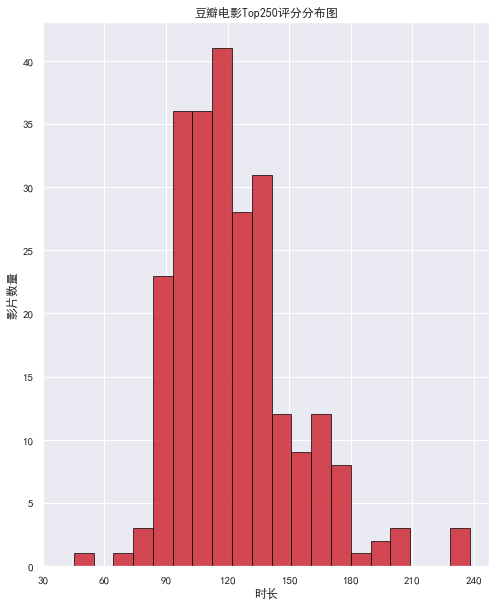

In [71]:
# 分数分布
import numpy as np
import seaborn as sns

sns.set(font='SimHei')  # 解决Seaborn中文显示问题
plt.figure(figsize=(8, 10))
step=25
plt.hist(time_list
        ,  facecolor="#c7000b", bins=20,
        edgecolor="black", alpha=0.7)

sns.set_style('darkgrid')

plt.title("豆瓣电影Top250评分分布图")
plt.xlabel("时长")
plt.ylabel("影片数量")
plt.savefig("anlysis/电影片长直方图.svg")
ticks = np.arange(30, 270, 30)
plt.xticks(ticks, ticks)


250部电影片长分布挺集中的，其中，最长的电影有238分钟，最短的只有45分钟，平均片长是118分钟，通过查看数据可以发现，片长最长的是《乱世佳人》，片长最短的是《萤火之森》。



In [72]:
df['片长'] = df['片长'].astype('int')


In [73]:

sum(df['片长'] > 80)


247

In [74]:
len(df.loc[(df['片长'] <= 150) & (df['片长'] >= 90)])


194

In [75]:
print(df[df['片长'] == '238']['电影名称'])
print(df[df['片长'] == '45']['电影名称'])


Series([], Name: 电影名称, dtype: object)
Series([], Name: 电影名称, dtype: object)


### 电影排名&评分&评分人数情况分析


用matplotlib绘图，将电影排名、评分、评分人数，3个维度的数据绘制在一张图上

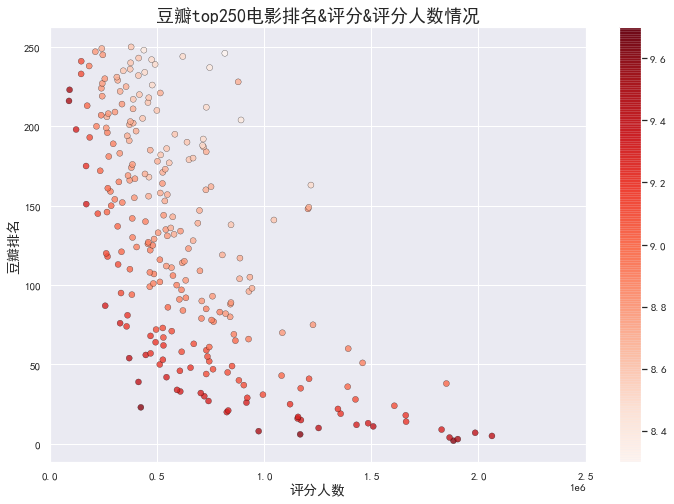

In [76]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文字体设置-黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
x5 = df['评分人数'].tolist()
y5 = df['评分'].tolist()
z = df['排名'].tolist()

plt.figure(figsize=(12, 8))
plt.scatter(x=x5,
            y=z,
            cmap='Reds',
            marker='o',
            c=y5,   # 数字越大，颜色越深，评分越高
            alpha=0.8,
            linewidths=0.3,
            edgecolors='Black')

plt.title('豆瓣top250电影排名&评分&评分人数情况', fontsize=18)
plt.xlabel('评分人数', fontsize=14)
plt.ylabel('豆瓣排名', fontsize=14)
plt.xlim(0, 2500000)
plt.colorbar()
plt.savefig("anlysis/豆瓣top250电影排名&评分&评分人数情况.svg")


豆瓣电影Top250中的所有电影评分都在8分以上，最低评分8.3是国产电影《驴得水》，最高评分9.7《肖申克的救赎》,豆瓣电影TOP250中TOP50的平均得分高达 9.266。评分人数大部分在100万以内,只有35部高于100万人次评价,其中27部都是排名TOP50以内的电影。可以大致看出，非常经典的电影，豆瓣排名、评分人数、评分都很高

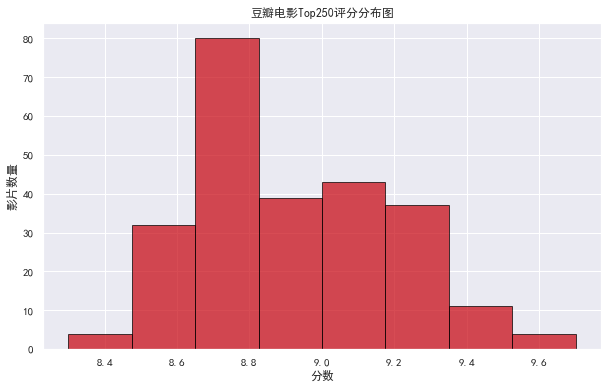

In [77]:
# 分数分布
plt.figure(figsize=(10, 6))
plt.hist(list(df["评分"]), bins=8, facecolor="#c7000b",
        edgecolor="black", alpha=0.7)
plt.title("豆瓣电影Top250评分分布图")
plt.xlabel("分数")
plt.ylabel("影片数量")
plt.savefig("anlysis/电影评分分析.svg")
plt.show()


In [78]:
# 最高评分
df[df['评分'] == df['评分'].max()]


,排名,电影名称,又名,导演,编剧,主演,类型,制片国家/地区,上映日期,片长,评分,评分人数,短评,豆瓣链接
0,1,肖申克的救赎,月黑高飞(港)/刺激1995(台)/地狱诺言/铁窗岁月/消香克的救赎,[弗兰克·德拉邦特],"[弗兰克·德拉邦特, 斯蒂芬·金]","[蒂姆·罗宾斯, 摩根·弗里曼, 鲍勃·冈顿, 威廉姆·赛德勒, 克兰西·布朗, 吉尔·贝罗...","[剧情, 犯罪]",[美国],1994,142,9.7,2533625,希望让人自由。,https://movie.douban.com/subject/1292052/


In [79]:
# 最低评分
df[df['评分'] == df['评分'].min()]


,排名,电影名称,又名,导演,编剧,主演,类型,制片国家/地区,上映日期,片长,评分,评分人数,短评,豆瓣链接
245,246,驴得水,Mr.Donkey,"[周申, 刘露]","[周申, 刘露]","[任素汐, 大力, 刘帅良, 裴魁山, 阿如那, 韩彦博, 卜冠今, 王堃, 高阳, 苏千越...","[剧情, 喜剧]",[中国大陆],2016,111,8.3,816355,过去的如果就让它过去了，未来只会越来越糟！,https://movie.douban.com/subject/25921812/


In [80]:

print("豆瓣电影TOP250中TOP50的平均得分高达", df.iloc[0:50, ]["评分"].mean())


豆瓣电影TOP250中TOP50的平均得分高达 9.266000000000005


In [81]:
num_m=len(df[df["评分人数"] > 1000000])
print(f"至少100万人评分的电影有{num_m}部",)
df_=df[df["评分人数"] > 1000000]
num_50=len(df_[df_['排名'] < 50])
print(f"其中位于TOP50的有{num_50}部",)


至少100万人评分的电影有35部
其中位于TOP50的有27部


In [118]:
df1 = df.sort_values(by="评分人数", ascending=False).iloc[0:20, ]
comments=(
    Bar()
    .add_xaxis(df1["电影名称"].to_list())
    .add_yaxis("评分人数", df1["评分人数"].to_list())
    .reversal_axis()
    .set_series_opts(label_opts=opts.LabelOpts(position="right"))
    .set_global_opts(
        title_opts=opts.TitleOpts(title="豆瓣电影Top250中最多评分人数的电影（前20部）"),
        #工具栏
        toolbox_opts=opts.ToolboxOpts(
        is_show=True,
        pos_top="top",
        pos_left="right",
        feature={
                "saveAsImage": {},
                "dataZoom": {"yAxisIndex": "none"},
                "restore": {},
                "magicType": {"show": True, "type": ["line", "bar"]},
                "dataView": {}}
    ))
    )
comments.render("anlysis/电影评分人数Top20.html")
comments.render_notebook()


在电影评分人数TOP20中,可以看到肖申克的救赎不愧为榜1,253万评分人次,独领风骚,其次是这个杀手不太冷206万评分,千与千寻198万评分,阿甘正传190万评分人次,霸王别姬作为中国最好电影,评分人次也有188万(很遗憾的说,我还没看过霸王别姬,年龄太小啦,看也看不懂)

In [83]:
df1=df.sort_values(by="评分人数", ascending=False)


def find_China(area_list):
    find = re.compile('中国+')
    flag = False
    for i in area_list:
        m = find.search(i)
        if m:
            return True
    return False


df2=df1[[find_China(x) for x in df1["制片国家/地区"].tolist()]][["排名","电影名称","导演","编剧","评分","评分人数"]].iloc[0:30]
print(df2.to_markdown(index=False))


|   排名 | 电影名称             | 导演                  | 编剧                                                              |   评分 |   评分人数 |
|-------:|:---------------------|:----------------------|:------------------------------------------------------------------|-------:|-----------:|
|      2 | 霸王别姬             | ['陈凯歌']            | ['芦苇', '李碧华']                                                |    9.6 |    1883284 |
|     38 | 我不是药神           | ['文牧野']            | ['韩家女', '钟伟', '文牧野']                                      |    9   |    1850246 |
|     51 | 让子弹飞             | ['姜文']              | ['朱苏进', '述平', '姜文', '郭俊立', '危笑', '李不空', '马识途']  |    8.9 |    1459151 |
|     60 | 绿皮书               | ['彼得·法雷里']       | ['尼克·瓦莱隆加', '布莱恩·库瑞', '彼得·法雷里']                   |    8.9 |    1392106 |
|     19 | 大话西游之大圣娶亲   | ['刘镇伟']            | ['刘镇伟']                                                        |    9.2 |    1356821 |
|     41 | 少年派的奇幻漂流     | ['李安']              | ['扬·马特尔', '大卫·麦基']     

In [85]:
# 保存电影评分高于9.0的电影
movie_9 = df[df["评分"] >= 9.0]
movie_9.to_excel(f"movies/评分超过9.0的电影(共{len(movie_9)}部).xlsx", index=False)


In [195]:
df_=pd.read_excel(f"movies/评分超过9.0的电影(共{len(movie_9)}部).xlsx")

In [196]:
df_.head(n=2)

,排名,电影名称,又名,导演,编剧,主演,类型,制片国家/地区,上映日期,片长,评分,评分人数,短评,豆瓣链接
0,1,肖申克的救赎,月黑高飞(港)/刺激1995(台)/地狱诺言/铁窗岁月/消香克的救赎,['弗兰克·德拉邦特'],"['弗兰克·德拉邦特', '斯蒂芬·金']","['蒂姆·罗宾斯', '摩根·弗里曼', '鲍勃·冈顿', '威廉姆·赛德勒', '克兰西·...","['剧情', '犯罪']",['美国'],1994,142,9.7,2533625,希望让人自由。,https://movie.douban.com/subject/1292052/
1,2,霸王别姬,再见，我的妾/FarewellMyConcubine/AdieuMaConcubine,['陈凯歌'],"['芦苇', '李碧华']","['张国荣', '张丰毅', '巩俐', '葛优', '英达', '蒋雯丽', '吴大维',...","['剧情', '爱情', '同性']","['中国大陆', '中国香港']",1993,171,9.6,1883284,风华绝代。,https://movie.douban.com/subject/1291546/


In [212]:
def meval(input):
    try:
        eval(input)
    except:
        return input
    else:
        return eval(input)

def recover_df(df):
    for column in df.columns:
        df[column] = df[column].apply(lambda x: meval(x))
    return df


df_ = pd.read_excel(f"movies/评分超过9.0的电影(共{len(movie_9)}部).xlsx")
df_=recover_df(df_)
df_["导演"][1]


['陈凯歌']